# AJUSTEMENT BILATERAL DE VALEUR DE CREDIT



Ce notebook Python implémente les algorithmes 1, 2 et 3 de l'article *Bilateral counterparty risk valuation with stochastic dynamical models and application to Credit Default Swaps* de Brigo et Capponi (2008). Lien vers l'article: https://arxiv.org/pdf/0812.3705.pdf.

Nous introduisons, étape par étape, les différents outils mobilisés pour calculer l'ajustement bilatéral de valeur de crédit (BRCVA).


### SOMMAIRE:
### 1. Calcul de la fonction de répartition d'un processus CIR intégré
### 2. Copules et dérivées de copules
### 3. Ajustement de la composante déterministe de l'intensité aux données de marché
### 4. Simulation des temps de défaut
### 5. Calcul de la BRCVA par méthode de Monte Carlo (algorithmes 1, 2 et 3 de l'article)
### 6. Pistes d'amélioration



Au début de chaque partie, nous présentons brièvement le contexte d'utilisation de l'outil en faisant référence à l'article. Nous citons aussi les documents externes qui nous ont servi à construire nos algorithmes.

N'hésitez pas à nous contacter si vous avez des questions ou remarques concernant notre travail.

Johan MACQ _ johan.macq@ensae-paristech.fr

Jeremy MARCK _ jeremy.marck@ensae.fr

Antoine LEFEBVRE _ antoine.lefebvre@ensae-paristech.fr


In [1]:
from scipy import integrate
from scipy import stats
from scipy.stats import norm
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from cmath import *
import math
import pandas as pd

## 1. Calcul de la fonction de répartition d'un processus CIR intégré:

Le calcul de la BRCVA repose sur les formules (4.4) et (4.6) de l'article (page 12). Ces formules font intervenir des fonctions de répartition de processus CIR integrés et shiftés. C'est de ce type de fonction dont il s'agit dans l'algorithme 3 page 14 lorsque les auteurs écrivent "p_k = CDF(x_k)".

Pour calculer la fonction de répartition d'un CIR intégré, le plus rapide est de passer par sa fonction caractéristique. Cette dernière est en effet parfaitement connue. Teng, Ehrhardt et Gunther proposent une méthode d'évaluation numérique de la fonction de répartition d'un processus CIR intégré dans leur article *Numerical evaluation of complex logarithms in the Cox–Ingersoll–Ross model* (2012). Lien vers l'article: https://www.researchgate.net/publication/265226906_Numerical_Evaluation_of_Complex_Logarithms_in_the_Cox-Ingersoll-Ross_Model. Nous avons exploité leurs résultats pour implémenter la fonction de répartition d'un CIR intégré.

Dans la cellule suivante, nous introduisons différentes fonctions imbriquées les unes dans les autres. Les noms donnés aux fonctions ont été conservés par rapport à l'article de Teng, Ehrhardt et Gunther.

In [28]:
def b(u,kappa,mu,nu):
    
    # u : point d'évaluation de la fonction b
    # kappa: force de rappel dans le modèle CIR
    # mu: moyenne dans le modèle CIR
    # nu: volatilité dans le modèle CIR
    
    a = complex(kappa**2, -2*nu**2*u)
    r = a**(0.5) # racine carrée de a
    if r.real>=0:
        return(r)
    else:
        return(0)

def a(u,kappa,mu,nu):
    return((kappa+b(u,kappa,mu,nu))/(kappa-b(u,kappa,mu,nu)))

def c(u,kappa,mu,nu):
    return(b(u,kappa,mu,nu)/(kappa-b(u,kappa,mu,nu)))

def C(t,u,kappa,mu,nu):
    return(c(u,kappa,mu,nu)*exp((kappa+b(u,kappa,mu,nu))*t/2)/(a(u,kappa,mu,nu)*exp(b(u,kappa,mu,nu)*t)-1))

def A(t,u,kappa,mu,nu):
    alpha = 2*kappa*mu/nu**2
    return(alpha*log(C(t,u,kappa,mu,nu))+alpha*log(2))

def B(t,u,kappa,mu,nu):
    x = 2*u*complex(0,1)/(kappa-b(u,kappa,mu,nu))
    y = exp(b(u,kappa,mu,nu)*t)-1
    z = a(u,kappa,mu,nu)*exp(b(u,kappa,mu,nu)*t)-1
    return(x*y/z)
    
def phi(t,u,kappa,mu,nu,y0): # fonction caractéristique
    return(exp(A(t,u,kappa,mu,nu)+B(t,u,kappa,mu,nu)*y0))

def g(t,u,kappa,mu,nu,y0,yt):
    return((exp(-u*yt*complex(0,1))*phi(t,u,kappa,mu,nu,y0)/(complex(0,1)*u)).real)

def f(u,t,kappa,mu,nu,y0,yt): # densité de probabilité
    a_inf = (kappa*mu*t+y0)/nu
    return(1/2-1/(u*math.pi*a_inf)*g(t,-log(u)/a_inf,kappa,mu,nu,y0,yt))

Ci-dessous, la fonction de répartition d'un CIR intégré:

In [29]:
def F(yt,t,i,kappa,mu,nu,y0):
    kappa = kappa[i]
    mu = mu[i]
    nu = nu[i]
    y0 = y0[i]
    return(integrate.quad(f, 0, 1, args=(t,kappa,mu,nu,y0,yt))[0])

La cellule suivante présente différents jeux de paramètres correspondant à différents profils de risque. Les valeurs sont celles de la table 2 page 15 de l'article de Brigo et Capponi.

In [30]:
# en position 0: "low risk"
# en position 1: "middle risk"
# en position 2: "high risk"

y0 = [0.00001, 0.01, 0.03] # valeur initiale du processus CIR
kappa = [0.9, 0.8, 0.5]
mu = [0.0001, 0.02, 0.05]
nu = [0.01, 0.2, 0.5]

Et ensuite le tracé de la fonction de répartition pour les différents profils de risque:

C:\Users\johan\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
C:\Users\johan\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
C:\Users\johan\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance


Text(0.5,1,'Fonctions de répartition des CIR intégrés pour différents profils de risque')

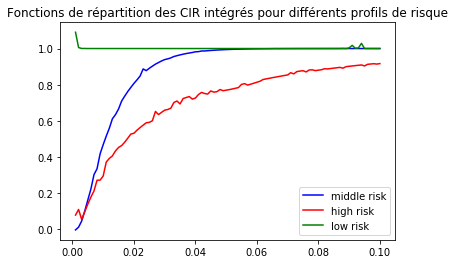

In [31]:
t = 1 # CIR intégrés jusqu'à t = 1 an
cdfm = [] # CDF middle risk
cdfr = [] # high risk
cdfl = [] # low risk
points = np.linspace(0.001, 0.1, 100)
for x in points:
    cdfm.append(F(x,t,1,kappa,mu,nu,y0))
    cdfr.append(F(x,t,2,kappa,mu,nu,y0))
    cdfl.append(F(x,t,0,kappa,mu,nu,y0))

plt.plot(points, cdfm, color = 'blue',label = 'middle risk')
plt.plot(points, cdfr, color = 'red', label = 'high risk')
plt.plot(points, cdfl, color = 'green', label = 'low risk')
plt.legend()
plt.title('Fonctions de répartition des CIR intégrés pour différents profils de risque', loc = 'center')

#### Remarques:
- Pour le profil peu risqué (courbe verte), la fonction de répartition vaut 1 très rapidement. On peut dire que le CIR intégré du profil peu risqué est "presque sûrement petit". Par conséquent, son instant de défaut, inversement proportionnel à l'intensité (et au CIR intégré), sera donc très grand! La position relative des courbes est donc conforme à l'intuition.
- On remarque des oscillations sur le tracé des courbes. Cela est dû aux oscillations de la fonction caractéristique. Un moyen de limiter ces oscillations et d'avoir recours à une intégration numérique adaptative de Gauss-Lobatto, comme le préconisent Teng, Ehrhardt et Gunther.

## 2. Copules et dérivées de copules:

Le calcul de la BRCVA repose également sur le calcul de fonctions exotiques dépendant de copules et de leurs dérivées. C'est le cas des fonctions (4.5) et (4.7) (p.12-13) utilisées dans l'algorithme 3 (p.14).

Dans l'article, les temps de défauts sont corrélés au moyen d'une copule gaussienne. La copule gaussienne s'exprime facilement en fonction de l'inverse de la fonction de répartition de la loi normale centrée réduite et de la fonction de répartition d'une gaussienne multivariée.

La cellule suivante définit des copules bivariées et trivariées associées à une loi gaussienne de moyenne *mean* et de matrice de covariance *covariance*. On retrouve ensuite des propriétés des copules.

In [49]:
# copules bivariées et trivariées
def copule_biv(a,b,mean,covariance):
    return(multivariate_normal(mean, covariance).cdf(norm.ppf([a,b])))

def copule_triv(a,b,c,mean,covariance):
    return(multivariate_normal(mean, covariance).cdf(norm.ppf([a,b,c])))


mean_biv = [0,0]
cov_biv = [[1,0],[0,1]]
print('C(u,1)=u:', copule_biv(0.3,1,mean_biv,cov_biv))

mean_triv = [0,0,0]
cov_triv = [[1,-0.2,-0.2],[-0.2,1,-0.2],[-0.2,-0.2,1]]
print('C(1,1,1)=1:', copule_triv(1,1,1,mean_triv,cov_triv))

C(u,1)=u: 0.29999999999999993
C(1,1,1)=1: 1.0


Dans la cellule suivante, nous calculons les dérivées de copules bivariées et trivariées par rapport à leurs différentes variables via un taux d'accroissement.

In [50]:
### dérivées des copules trivariées par rapport aux variables 1, 2 et 3:

def dC1_triv(a,b,c,mean,cov):
    h = 0.0001
    return((copule_triv(a+h,b,c,mean,cov)-copule_triv(a-h,b,c,mean,cov))/(2*h))

def dC2_triv(a,b,c,mean,cov):
    h = 0.0001
    return((copule_triv(a,b+h,c,mean,cov)-copule_triv(a,b-h,c,mean,cov))/(2*h))

def dC3_triv(a,b,c,mean,cov):
    h = 0.0001
    return((copule_triv(a,b,c+h,mean,cov)-copule_triv(a,b,c-h,mean,cov))/(2*h))


### dérivées des copules bivariées par rapport aux variables 1, 2 et 3:

def dC1_biv(a,b,mean,cov):
    h = 0.0001
    return((copule_biv(a+h,b,mean,cov)-copule_biv(a-h,b,mean,cov))/(2*h))

def dC2_biv(a,b,mean,cov):
    h = 0.0001
    return((copule_biv(a,b+h,mean,cov)-copule_biv(a,b-h,mean,cov))/(2*h))

Et voici la fonction des formules (4.5) et (4.7) de l'article utilisée dans l'algorithme 3.

In [51]:
def Cf(u1,U,index,U02,U12,U20,U10,mean,covariance):
    
    # si 'index' en argument vaut 2, renvoie la fonction (4.5) 
    # si 'index' en argument vaut 0, renvoie la fonction (4.7)
    
    m = np.asarray(mean)
    cov = np.asarray(covariance)
    m02 = m[np.ix_([0,2])]
    c02 = cov[np.ix_([0,2],[0,2])]
    if index==2:
        m12 = m[np.ix_([1,2])]
        c12 = cov[np.ix_([1,2],[1,2])]
        num = dC2_biv(u1,U,m12,c12)-dC3_triv(U02,u1,U,m,cov)-dC2_biv(U12,U,m12,c12)+dC3_triv(U02,U12,U,m,cov)
        den = 1 - dC2_biv(U02,U,m02,c02) - dC2_biv(U12,U,m12,c12) + dC3_triv(U02,U12,U,m,cov)
        return(num/den)
    else:
        m01 = m[np.ix_([0,1])]
        c01 = cov[np.ix_([0,1],[0,1])]
        num = dC2_biv(U,u1,m01,c01)-dC3_triv(U,u1,U20,m,cov)-dC2_biv(U,U10,m01,c01)+dC3_triv(U,U10,U20,m,cov)
        den = 1 - dC2_biv(U,U20,m02,c02) - dC2_biv(U,U10,m01,c01) + dC3_triv(U,U10,U20,m,cov)
        return(num/den)

    
print(Cf(0.1,0.2,2,0.3,0.4,0.5,0.6,mean_triv,cov_triv))
print(Cf(0.9,0.2,0,0.3,0.4,0.5,0.6,mean_triv,cov_triv))

-0.43508334962113754
-0.03622694721397755


## 3. Ajustement de la composante déterministe de l'intensité aux données de marché

Il s'agit de calculer dans cette partie la composante $\psi_{i}(t,\beta_{i})$  de l'intensité (cf. formule (3.9) p.10). Les auteurs "calent" les probabilités de défaut de leur modèle sur les probabilités de défaut contenues dans les informations de marché (cf. formules (5.1) à (5.3) p.15-16). Les probabilités de défaut de marché découlent des informations contenues dans les spreads et les taux de recouvrement. Le lien est obtenu par la formule suivante: Q(tau_i > t) = exp(-s(i,t)t/LGD(i) ). Source: chapitre 24 "Credit Risk" de la 9e édition de l'ouvrage *Options, futures and other derivatives* de John C. Hull.

Dans la cellule suivante, nous introduisons des données de marché pour les taux de recouvrement et les spreads. Ce sont les mêmes données que celles figurant table 3 page 15 de l'article. 

In [52]:
# losses given default des différents profils de risque
LGD = [0.6,0.65,0.7]

# spreads de crédit
low = np.asarray([0,0,0,1,1,1,1,1,1,1])*0.0001
mid = np.asarray([92,104,112,117,120,122,124,125,126,127])*0.0001
high = np.asarray([234,244,248,250,251,252,253,253,254,254])*0.0001
maturity = range(1,11)
spreads = pd.DataFrame({'low':low,'middle':mid,'high':high}, index = maturity)
spreads

,low,middle,high
1,0.0000,0.0092,0.0234
2,0.0000,0.0104,0.0244
3,0.0000,0.0112,0.0248
4,0.0001,0.0117,0.0250
5,0.0001,0.0120,0.0251
6,0.0001,0.0122,0.0252
7,0.0001,0.0124,0.0253
8,0.0001,0.0125,0.0253
9,0.0001,0.0126,0.0254
10,0.0001,0.0127,0.0254


Fonction qui calcule le spread du profil de risque i à un instant t quelconque, par interpolation linéaire des taux cotés sur le marché:

In [53]:
def spread(t, i, spreads):
    if t<1:
        return(spreads.iloc[0,i])
    if t>spreads.shape[0]:
        return(spreads.iloc[-1,i])
    if (t>=1)&(t<=spreads.shape[0]):
        if t%1==0:
            return(spreads.iloc[int(t)-1,i])
        else:
            a = math.floor(t)-1
            b = a+1
            delta = t - b
            return( spreads.iloc[a,i] + (spreads.iloc[b,i]-spreads.iloc[a,i])*delta )

spread(2.5, 2, spreads) # spread maturité 2.5 ans profil de risque 2 (high)

0.024600000000000004

Fonction de survie du profil de risque i:

In [54]:
def Q(t, i, spreads, LGD):
    return(math.exp(-spread(t, i, spreads)*t/LGD[i]))

print('Proba de survie du profil risqué après 10 ans:', Q(10,2,spreads,LGD))
print('Proba de survie du profil non risqué après 10 ans:', Q(10,0,spreads,LGD))

Proba de survie du profil risqué après 10 ans: 0.6956858100877537
Proba de survie du profil non risqué après 10 ans: 0.9983347214509387


Ci-après, prix à t du zéro-coupon de maturité T dans le modèle CIR (formule fermée donnée dans le cours de taux et accessible au lien suivant: https://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model). On dit ici "zéro-coupon" mais en réalité la quantité P_CIR obtenue ci-dessous n'a aucun rapport avec un zéro-coupon. C'est l'espérance d'un processus CIR intégré utilisé pour modéliser une intensité de défaut stochastique. Plus P_CIR(i) est grand, plus l'intensité  de défaut de i sera grande, plus tôt aura lieu son défaut.

In [55]:
def P_CIR(t,T,i,kappa,mu,nu,y0):
    h = (kappa[i]**2+2*nu[i]**2)**0.5
    A_num = 2*h*math.exp((kappa[i]+h)*(T-t)/2)
    A_denom = 2*h + (kappa[i]+h)*(math.exp((T-t)*h)-1)
    A = (A_num/A_denom)**(2*kappa[i]*mu[i]/nu[i]**2)
    B = 2*(math.exp((T-t)*h)-1)/A_denom
    return(A*math.exp(-B*y0[i]))

print(P_CIR(0,1,0,kappa,mu,nu,y0))
print(P_CIR(0,1,2,kappa,mu,nu,y0))

0.9999593441204526
0.9671983731324376


Et voilà la fonction $\psi_{i}(t,\beta_{i})$ qu'on cherchait à coder:

In [56]:
def psi(t,i,kappa,mu,nu,y0,spreads,LGD):
    return(np.log(P_CIR(0,t,i,kappa,mu,nu,y0)/Q(t, i, spreads, LGD)))

print(psi(1,0,kappa,mu,nu,y0,spreads,LGD))
print(psi(1,2,kappa,mu,nu,y0,spreads,LGD))

-4.0656706020051536e-05
7.690970718011918e-05


## 4. Simulation des temps d'arrêt:

Les temps d'arrêts sont obtenus en inversant l'intensité stochastique intégrée et sont supposés corrélés via une copule gaussienne trivariée et  (formules (3.4) à (3.6) p.9). Pour simuler ces temps d'arrêts on procède en 3 étapes:
1. On tire un triplet de lois uniformes corrélées par une copule (en passant par une décomposition de Cholesky de la matrice de covariance, comme expliqué ici: https://stats.stackexchange.com/questions/37424/how-to-simulate-from-a-gaussian-copula)
2. On transforme le triplet (u1, u2, u3) obtenu pour obtenir ksi1, ksi2, ksi3 qui suivent des lois exponentielles (formule (3.5))
3. On calcule ensuite tau_i (formule (3.4)) en générant un CIR shifté (shifté de la fonction $\psi$ précédemment calculée) tant que l'intégrale de ce CIR shifté est inférieure à ksi_i. Source: formule (2.1) de l'article *On Cox Processes and Credit Risky Securities* de Lando accessible ici: https://www.researchgate.net/publication/226786879_On_Cox_Processes_and_Credit_Risky_Securities.

Etape 1:

In [58]:
def triv_copula(mean, covariance):
    d = len(mean) # =3/trivariée
    A = np.linalg.cholesky(covariance) # Cholesky triangulaire inférieure
    Z = np.random.normal(0,1,d)
    X = np.dot(A,Z)
    U = stats.norm.cdf(X)
    return(U)


mean = [0,0,0]
covariance = [[1,-0.2,-0.2],[-0.2,1,-0.2],[-0.2,-0.2,1]]
triv_copula(mean,covariance)

array([0.26635393, 0.87175102, 0.80978753])

Etape 2:

In [59]:
ksi = -np.log(1-triv_copula(mean,covariance))
ksi

array([0.82161847, 0.80090905, 1.17259574])

Etape 3:

À noter que la fonction tau ci-dessous (qui inverse le CIR shifté) renvoie plusieurs paramètres: l'instant de défaut, l'intensité intégrée à l'instant de défaut, le CIR intégré à l'instant de défaut et enfin la trajectoire du CIR jusqu'à l'instant de défaut. Il est essentiel de conserver ces informations puisque le "payoff" de la BRCVA va être conditionné par le premier instant où l'une ou l'autre des parties va faire défaut.

Instant de défaut du profil le plus risqué (en années): 51.38000000000243


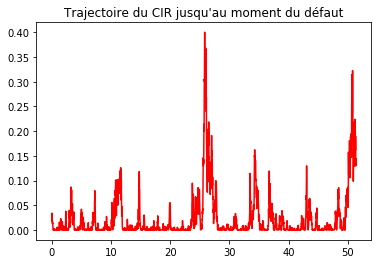

In [64]:
def tau(i,kappa,mu,nu,y0,spreads,LGD,delta,ksi):
    #delta: pas temporel
    
    # paramètres du chi deux
    df = (4*mu[i]*kappa[i])/(nu[i]**2)
    dt = delta
    C = (nu[i]**2*(1 - math.exp(-kappa[i]*dt)))/(4*kappa[i])
    D = (4*kappa[i]*math.exp(-kappa[i]*dt))/(nu[i]**2*(1 - math.exp(-kappa[i]*dt)))
    
    # paramètres actualisés dans le while
    t = delta #tau
    path = [y0[i]]
    Y = y0[i]*delta
    P = psi(t,i,kappa,mu,nu,y0,spreads,LGD)
    L = Y + P
    
    while (L<ksi[i]):
        
        t += delta
        y = C*np.random.noncentral_chisquare(df, D*path[-1])
        path.append(y)
        Y += y*delta
        P = psi(t,i,kappa,mu,nu,y0,spreads,LGD)
        L = Y + P
    
    return([t,L,Y,path]) #renvoie tau_i, LAMBDA_i(tau_i), Y_i_(tau_i) et y_i[tau_i]



delta = 1/50 # pas temporel pour la recherche du temps d'arrêt
info2 = tau(2,kappa,mu,nu,y0,spreads,LGD,delta,ksi)
tau2, tau2_path = [info2[_] for _ in [0,3]]
print('Instant de défaut du profil le plus risqué (en années):',tau2)
x = [k*delta for k in range(len(tau2_path))]
plt.plot(x, tau2_path, color = 'red')
plt.title("Trajectoire du CIR jusqu'au moment du défaut")
plt.show()

## 5. Calcul de la BRCVA par Monte Carlo (algorithmes 1, 2 et 3 p.13-14 de l'article):

Dans cette partie, nous implémentons les algorithmes 1, 2 et 3 de l'article pour le calcul de la BRCVA. Nous utilisons à cet effet les fonctions codées dans les parties précédentes. Il serait trop long d'expliquer en détail l'imbrication des différents algorithmes en jeu. Aussi, nous vous invitons à exécuter les 3 cellules suivantes pour vous rendre directement à la cellule de calcul de la BRCVA.

In [17]:
def algo1(N,S,Ta,Tb,Ti,d,kappa,mu,nu,y0,spreads,LGD,delta, mean, covariance):
    
    CUMBRCVAR = 0
    CUMBRCVAP = 0
    
    for k in range(N):
        ksi = -np.log(1-triv_copula(mean,covariance))
        
        tau0, L0_tau0, Y0_tau0, path0 = tau(0,kappa,mu,nu,y0,spreads,LGD,delta,ksi)
        tau1, L1_tau1, Y1_tau1, path1 = tau(1,kappa,mu,nu,y0,spreads,LGD,delta,ksi)
        tau2, L2_tau2, Y2_tau2, path2 = tau(2,kappa,mu,nu,y0,spreads,LGD,delta,ksi)
        
        if (tau2<tau0)&(tau2<tau1)&(tau2<Tb):

            U2 = 1-math.exp(-ksi[2])
            pos = len(path2)
            L0_tau2 = sum(path0[0:pos])*delta + psi(tau2,0,kappa,mu,nu,y0,spreads,LGD)
            L1_tau2 = sum(path1[0:pos])*delta + psi(tau2,1,kappa,mu,nu,y0,spreads,LGD)
            U02 = 1-math.exp(-L0_tau2)
            U12 = 1-math.exp(-L1_tau2)
            
            [BRCVAR2,BRCVAP2] = algo2(Ta,Tb,tau2,Ti,S,2,d,kappa,mu,nu,y0,spreads,LGD,U2,U02,U12,0,0,0,L1_tau2,0,mean,covariance)
            CUMBRCVAR += LGD[2]*BRCVAR2
            CUMBRCVAP += LGD[2]*BRCVAP2
            
        
        if (tau0<tau2)&(tau0<tau1)&(tau0<Tb):
        
            U0 = 1-math.exp(-ksi[0])
            pos = len(path0)
            L2_tau0 = sum(path2[0:pos])*delta + psi(tau0,2,kappa,mu,nu,y0,spreads,LGD)
            L1_tau0 = sum(path1[0:pos])*delta + psi(tau0,1,kappa,mu,nu,y0,spreads,LGD)
            U20 = 1-math.exp(-L2_tau0)
            U10 = 1-math.exp(-L1_tau0)
            
            [BRCVAR0,BRCVAP0] = algo2(Ta,Tb,tau0,Ti,S,0,d,kappa,mu,nu,y0,spreads,LGD,0,0,0,U0,U20,U10,0,L1_tau0,mean,covariance)
            CUMBRCVAR -= LGD[0]*BRCVAR0
            CUMBRCVAP -= LGD[0]*BRCVAP0
    
    return([CUMBRCVAR/N, CUMBRCVAP/N])

In [18]:
def algo2(Ta,Tb,Tj,Ti,S,index,d,kappa,mu,nu,y0,spreads,LGD,U2,U02,U12,U0,U20,U10,L1_tau2,L1_tau0,mean,covariance):
    
    term1, term2, term3 = 0, 0, 0
    t_start = max(Ta, Tj)
    Q_prev = algo3(t_start,index,kappa,mu,nu,y0,spreads,LGD,U2,U02,U12,U0,U20,U10,L1_tau2,L1_tau0,mean,covariance)
    
    # on suppose term1=0: pas de coupons courus
    for t in np.linspace(t_start, Tb, d):
        Q_curr = algo3(t,index,kappa,mu,nu,y0,spreads,LGD,U2,U02,U12,U0,U20,U10,L1_tau2,L1_tau0,mean,covariance)
        term3 += P_CIR(Tj,t,0,kappa,mu,nu,y0)*(Q_curr-Q_prev) #P_CIR prend index=0 car risk-free rate paramètres
        Q_prev = Q_curr
    
    # terme 2
    Ti = np.asarray(Ti)
    Ti = Ti[Ti>t_start].tolist() # paiements restants
    Ti = [t_start]+Ti
    for k in range(1,len(Ti)):
        alpha = Ti[k]-Ti[k-1]
        Q_curr = algo3(Ti[k],index,kappa,mu,nu,y0,spreads,LGD,U2,U02,U12,U0,U20,U10,L1_tau2,L1_tau0,mean,covariance)
        term2 += alpha*P_CIR(Tj,Ti[k],0,kappa,mu,nu,y0)*Q_curr
    
    #on assemble les termes du CDS
    CDSval = -S*term2 + LGD[1]*term3
    
    #
    if index==2:
        CDSr = P_CIR(0,Tj,0,kappa,mu,nu,y0)*max(0,CDSval) # vu de la date 0
        CDSp = P_CIR(0,Tj,0,kappa,mu,nu,y0)*max(0,-CDSval)
    if index==0:
        CDSr = P_CIR(0,Tj,0,kappa,mu,nu,y0)*max(0,-CDSval)
        CDSp = P_CIR(0,Tj,0,kappa,mu,nu,y0)*max(0,CDSval)
     
    #
    return([CDSr,CDSp])
         

In [19]:
def algo3(t,index,kappa,mu,nu,y0,spreads,LGD,U2,U02,U12,U0,U20,U10,L1_tau2,L1_tau0,mean,covariance): #on mettra des 0 si pas définis au moment d'utiliser l'algo

    xmax = 50*y0[index] # choix de xmax
    if index==2:
        xmax = 3
    if index==0:
        xmax = 10
    
    #choix du xmin: changement de variable conditionnellement à tau_index dans la fonction de rép. en (4.4-6)
    psi1t = psi(t,1,kappa,mu,nu,y0,spreads,LGD)
    if index==2:
        xmin = L1_tau2 - psi1t
    if index==0:
        xmin = L1_tau0 - psi1t
    #xmin = 0
    
    D = 100 # param à bien choisir également
    
    #initialisation des paramètres
    #Pk = [F(xmin,t,1,kappa,mu,nu,y0)]
    uk = 1-math.exp(-xmin-psi1t)
    if index==2:
        #Fk = [Cf(uk,U2,2,U02,U12,U20,U10,mean,covariance)]
        fprev = Cf(uk,U2,2,U02,U12,U20,U10,mean,covariance)
    if index==0:
        #Fk = [Cf(uk,U0,0,U02,U12,U20,U10,mean,covariance)]
        fprev = Cf(uk,U0,0,U02,U12,U20,U10,mean,covariance)
    Qi = 0

    for x in np.linspace(xmin,xmax,D):
        #Pk.append(F(x,t,1,kappa,mu,nu,y0))
        uk = 1-math.exp(-x-psi1t)
        if index==2:
            #Fk.append(Cf(uk,U2,2,U02,U12,U20,U10,mean,covariance))
            fcurr = Cf(uk,U2,2,U02,U12,U20,U10,mean,covariance)
        if index==0:
            #Fk.append(Cf(uk,U0,0,U02,U12,U20,U10,mean,covariance))
            fcurr = Cf(uk,U0,0,U02,U12,U20,U10,mean,covariance)
        s = F(x,t,1,kappa,mu,nu,y0)*(fcurr-fprev)
        if ~np.isnan(s):
            Qi += s
        fprev = fcurr
    
    return(Qi)

#### Calcul de BRCVA pour un jeu de paramètres donné:

In [27]:
### Paramètres pour le calcul de la BRCVA

# paramètres CIR de 0, 1 et 2:
y0 = [0.03, 0.05, 0.03]
kappa = [0.5, 0.3, 0.5]
mu = [0.05, 0.08, 0.05]
nu = [0.5, 0.8, 0.5]

# autres paramètres:
Ta = 1 # date de commencement du CDS
Tb = 5 # date d'expiration du CDS
Ti = [0.5*k for k in range(3,2*Tb+1)] # [1.5, ... Tb], il s'agit de l'échéancier du CDS
delta = 0.1 # pas pour la recherche du temps d'arrêt (algorithme tau de la section 4)
d = 5 # pas pour la discrétisation de l'intégrale dans le payoff du CDS
mean = [0,0,0] # paramètre de copule pour la corrélation des temps de défaut
covariance = [[1,-0.2,-0.2], [-0.2,1,-0.2], [-0.2,-0.2,1]] # paramètre de copule
S = 0.02 # taux de prime versée dans le cadre du CDS
N = 10 # nombre de boucles pour la simulation par Monte Carlo dans l'algorithme 1


# Calcul de la BRCVA
print('[BRCVAR, BRCVAP] = ', algo1(N,S,Ta,Tb,Ti,d,kappa,mu,nu,y0,spreads,LGD,delta,mean,covariance))

## 6. Pistes d'amélioration:

Notre algorithme de calcul de la BRCVA est relativement lent. Cela est dû à l'imbrication de nombreuses boucles: pour chaque simulation, il faut calculer un payoff de CDS qui nécessite de discrétiser une intégrale; discrétisation dont le pas est à chaque étape calculé lui-même par discrétisation d'une autre intégrale... Nous citons ci-dessous 2 pistes d'amélioration de notre travail:
- une réflexion doit être menée sur le choix des pas de discrétisation dans les différentes approximations d'intégrales (algorithmes 2 et 3);
- une procédure d'intégration numérique adaptative de Gauss-Lobatto doit être implémentée pour limiter les oscillations de la fonction de répartition du processus CIR intégré.


In [31]:
covariance = [[1,0,0], [0,1,-0.99], [0,-0.99,1]]
R_list = []
P_list = []

for i in range(0,10):
    covariance = [[1,0,0], [0,1,-0.99+i*0.2], [0,-0.99+i*0.2,1]]
    R , P = algo1(N,S,Ta,Tb,Ti,d,kappa,mu,nu,y0,spreads,LGD,delta,mean,covariance)
    R_list.append(R)
    P_list.append(P)
    if i+1==10:
        covariance = [[1,0,0], [0,1,0.99], [0,0.99,1]]
        R , P = algo1(N,S,Ta,Tb,Ti,d,kappa,mu,nu,y0,spreads,LGD,delta,mean,covariance)
        R_list.append(R)
        P_list.append(P)

C:\Users\johan\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
C:\Users\johan\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


Text(0.5,1,'BR-CVA - Receiver investor')

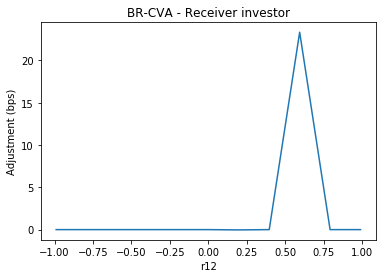

In [35]:
plt.plot(np.linspace(-0.99,0.99,11),np.array(P_list)*10000)
plt.xlabel('r12')
plt.ylabel('Adjustment (bps)')
plt.title('BR-CVA - Receiver investor')